<a href="https://www.kaggle.com/code/shandeep777/customer-segmentaion?scriptVersionId=250433176" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Import liabreries

In [1]:
!pip install nbformat > /dev/null 2>&1

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import plotly.colors

In [3]:
data = pd.read_csv('/kaggle/input/online-retail-dataset/online_retail.csv')

In [4]:
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Drop Null value

In [6]:
data.dropna(subset=['CustomerID'],inplace=True)

### Change data type of `InvoiceDate` column

In [7]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

### Create `total_amount` column by multiplying `Quantity` and `UnitPrice` column

In [8]:
data['total_amount'] = data['Quantity'] * data['UnitPrice']

In [9]:
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00


In [10]:
reference_date = pd.Timestamp(dt.now().date())

In [11]:
from datetime import timedelta

In [12]:
reference_date = data['InvoiceDate'].max() + timedelta(days=1)
reference_date

Timestamp('2011-12-10 12:50:00')

In [13]:
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                      # Frequency
    'total_amount': 'sum'                                       # Monetary
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [14]:
rfm.head(5)

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


### Define Outliers

In [15]:
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])

def RScore(x, p, d):
    if p == 'Recency':
        if x <= d[p][0.25]:
            return 4
        elif x <= d[p][0.50]:
            return 3
        elif x <= d[p][0.75]:
            return 2
        else:
            return 1
    else:
        if x <= d[p][0.25]:
            return 1
        elif x <= d[p][0.50]:
            return 2
        elif x <= d[p][0.75]:
            return 3
        else:
            return 4

In [16]:
rfm['R'] = rfm['Recency'].apply(RScore, args=('Recency', quantiles))
rfm['F'] = rfm['Frequency'].apply(RScore, args=('Frequency', quantiles))
rfm['M'] = rfm['Monetary'].apply(RScore, args=('Monetary', quantiles))

rfm.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2


In [17]:
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

In [18]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3
12347.0,2,182,4310.00,4,4,4,444,12
12348.0,75,31,1797.24,2,2,4,224,8
12349.0,19,73,1757.55,3,3,4,334,10
12350.0,310,17,334.40,1,1,2,112,4


In [19]:
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']

def assign_segment(score):
    if score < 5:
        return 'Low-Value'
    elif score < 9:
        return 'Mid-Value'
    else:
        return 'High-Value'

In [20]:
rfm['RFM_Segment_Label'] = rfm['RFM_Score'].apply(assign_segment)

In [21]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Segment_Label
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3,Low-Value
12347.0,2,182,4310.00,4,4,4,444,12,High-Value
12348.0,75,31,1797.24,2,2,4,224,8,Mid-Value
12349.0,19,73,1757.55,3,3,4,334,10,High-Value
12350.0,310,17,334.40,1,1,2,112,4,Low-Value


In [22]:
segment_counts = rfm['RFM_Segment_Label'].value_counts().reset_index()
segment_counts.columns = ['RFM_Segment', 'Count']
segment_counts = segment_counts.sort_values('RFM_Segment')

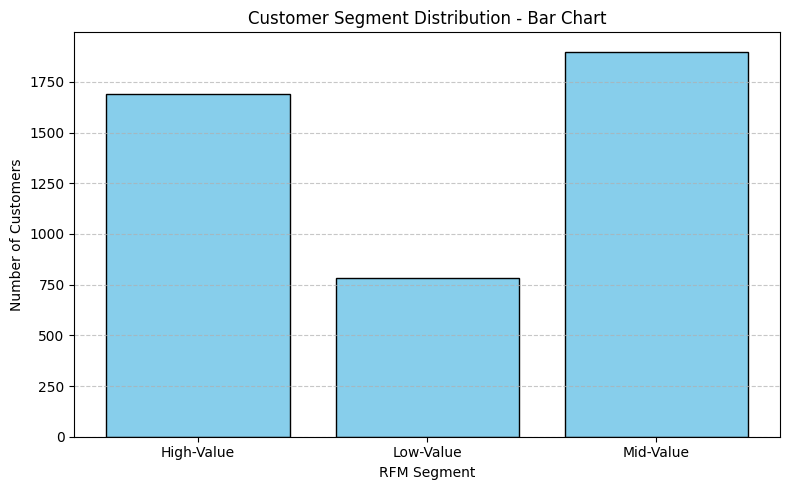

In [23]:
plt.figure(figsize=(8, 5))
plt.bar(segment_counts['RFM_Segment'], segment_counts['Count'], color='skyblue', edgecolor='black')

plt.title('Customer Segment Distribution - Bar Chart')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
bins = [0, 3.99, 4.99, 5.99, 8.99, 12]
labels = ['Lost', "Can't Lose", 'At Risk Customers', 'Potential Loyal', 'VIP/Loyal']

rfm['RFM_Customer_Segments'] = pd.cut(rfm['RFM_Score'], bins=bins, labels=labels)

In [25]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Segment_Label,RFM_Customer_Segments
CustomerID,,,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3,Low-Value,Lost
12347.0,2,182,4310.00,4,4,4,444,12,High-Value,VIP/Loyal
12348.0,75,31,1797.24,2,2,4,224,8,Mid-Value,Potential Loyal
12349.0,19,73,1757.55,3,3,4,334,10,High-Value,VIP/Loyal
12350.0,310,17,334.40,1,1,2,112,4,Low-Value,Can't Lose


In [26]:
segment_product_counts = rfm.groupby(['RFM_Segment_Label', 'RFM_Customer_Segments']).size().reset_index(name='Count')
                            

segment_product_counts = segment_product_counts.sort_values('Count', ascending=False)

/tmp/ipykernel_13/1349054636.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_product_counts = rfm.groupby(['RFM_Segment_Label', 'RFM_Customer_Segments']).size().reset_index(name='Count')


In [27]:
segment_product_counts

,RFM_Segment_Label,RFM_Customer_Segments,Count
4,High-Value,VIP/Loyal,1690
13,Mid-Value,Potential Loyal,1382
12,Mid-Value,At Risk Customers,517
5,Low-Value,Lost,392
6,Low-Value,Can't Lose,391
0,High-Value,Lost,0
1,High-Value,Can't Lose,0
2,High-Value,At Risk Customers,0
3,High-Value,Potential Loyal,0
7,Low-Value,At Risk Customers,0


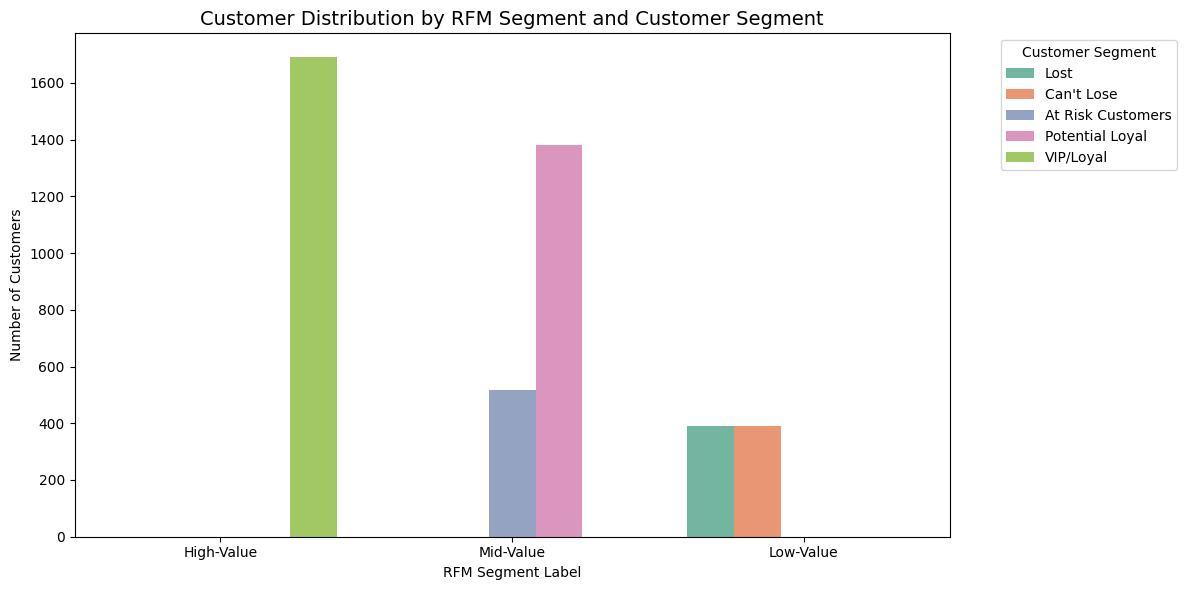

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=segment_product_counts,
    x='RFM_Segment_Label',
    y='Count',
    hue='RFM_Customer_Segments',
    palette='Set2'
)

# Add plot labels and title
plt.title('Customer Distribution by RFM Segment and Customer Segment', fontsize=14)
plt.xlabel('RFM Segment Label')
plt.ylabel('Number of Customers')
plt.legend(title='Customer Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Tidy layout
plt.tight_layout()
plt.show()